<a href="https://colab.research.google.com/github/rahulhirur/DLLab/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from math import floor
import neptune
import time
from tqdm import tqdm

**Task 1**

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
print(torch.randint(1, 10, (1, 1)))

tensor([[7]])


**Task 2**

In [4]:
# Load CIFAR-10 dataset
train_set_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set_raw = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
validation_set_raw, test_set_raw = torch.utils.data.random_split(test_set_raw, [0.8, 0.2])


100%|██████████| 170M/170M [00:03<00:00, 46.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Define CIFAR-10 classes
classes = train_set_raw.classes
print(f"The number of classes in the dataset - {len(classes)}")

print(f"The number of images in the training dataset - {len(train_set_raw)}")
print(f"The number of images in the test dataset - {len(test_set_raw)}")
print(f"The number of images in the validation dataset - {len(validation_set_raw)}")

The number of classes in the dataset - 10
The number of images in the training dataset - 50000
The number of images in the test dataset - 2000
The number of images in the validation dataset - 8000


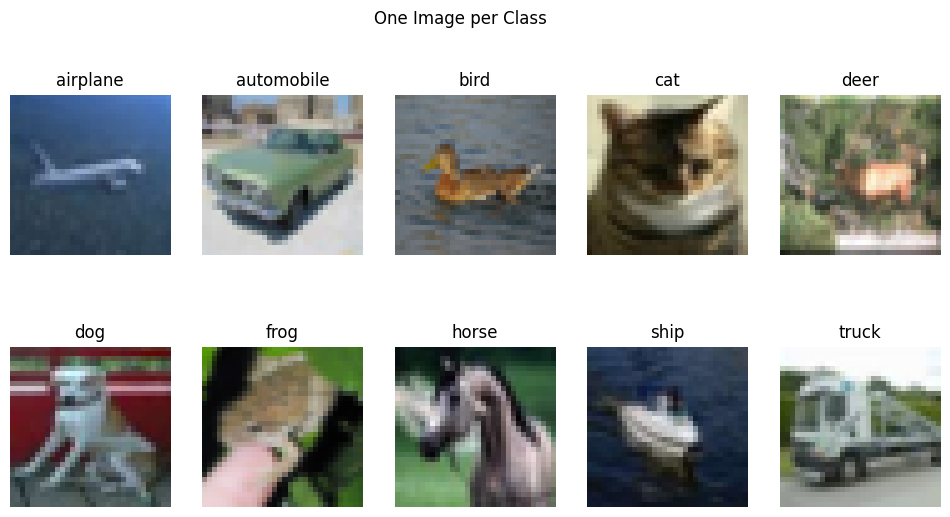

In [6]:
def show_images_per_class(dataset, classes):
    class_examples = {class_name: None for class_name in classes}

    for image, label in dataset:
        class_name = classes[label]
        if class_examples[class_name] is None:
            class_examples[class_name] = image
        if all(v is not None for v in class_examples.values()):  # Break when all classes are filled
            break

    # Plot images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('One Image per Class')
    for idx, (class_name, img) in enumerate(class_examples.items()):
        ax = axes[idx // 5, idx % 5]
        img = np.transpose(img, (1, 2, 0))

        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis('off')
    plt.show()

# Call the function with the transformed dataset
show_images_per_class(validation_set_raw, classes)

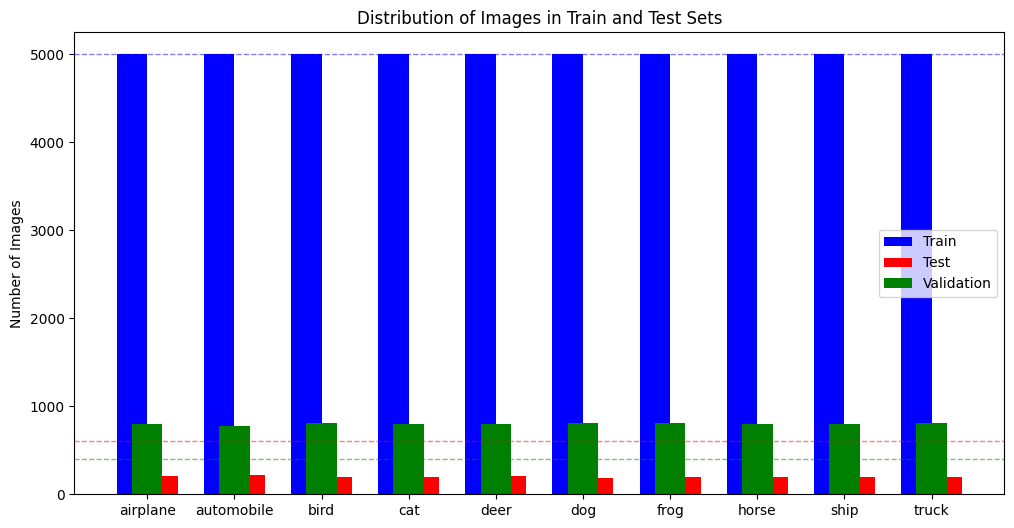

In [7]:
def plot_combined_histogram(train_dataset, test_dataset, val_dataset, classes):
    train_class_counts = {}
    test_class_counts = {}
    val_class_counts = {}

    for label in range(len(classes)):
      train_class_counts[label] = 0
      test_class_counts[label] = 0
      val_class_counts[label] = 0

    for _, label in train_dataset:
      train_class_counts[label] = train_class_counts[label] + 1

    for _, label in test_dataset:
        test_class_counts[label] = test_class_counts[label] + 1

    for _, label in val_dataset:
        val_class_counts[label] = val_class_counts[label] + 1

    x = np.arange(len(classes))

    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    rects1 = ax.bar(x - width/2, [train_class_counts.get(i,0) for i in range(len(classes))], width, label='Train',color="blue")
    ax.axhline(y=5000, color='blue', linestyle='--',linewidth=1,alpha=0.5)

    rects2 = ax.bar(x + width/2, [test_class_counts.get(i,0) for i in range(len(classes))], width, label='Test',color="red")
    ax.axhline(y=600, color='red', linestyle='--',linewidth=1,alpha=0.5)

    rects3 = ax.bar(x, [val_class_counts.get(i,0) for i in range(len(classes))], width, label='Validation',color="green")
    ax.axhline(y=400, color='green', linestyle='--',linewidth=1,alpha=0.5)

    ax.set_ylabel('Number of Images')
    ax.set_title('Distribution of Images in Train and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    plt.show()

plot_combined_histogram(train_set_raw, test_set_raw, validation_set_raw, classes)

In [8]:
def get_mean_std(dataset):
  # get the mean and std of the whole dataset
  images, _ = next(iter(dataset))
  print(images.mean(),  images.std())
  return images.mean().numpy(),  images.std().numpy()


In [9]:
meanVal, stdVal= get_mean_std(train_set_raw)


tensor(0.4057) tensor(0.2039)


In [77]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=meanVal, std=stdVal)
    ])

# Create a function to apply transformations on-demand
def apply_transform(dataset, transform):
    dataset.transform = transform
    return dataset

# Apply transformations to the dataset needed
# train_set_transformed = apply_transform(train_set_raw, transform)
# test_set_transformed = apply_transform(test_set_raw, transform)
# validation_set_transformed = apply_transform(validation_set_raw, transform)

train_set_transformed = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_set_transformed = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

validation_set_transformed, test_set_transformed = torch.utils.data.random_split(test_set_transformed, [0.8, 0.2])

Files already downloaded and verified
Files already downloaded and verified


In [78]:
get_mean_std(train_set_transformed)

tensor(4.3462e-09) tensor(1.)


(array(4.346172e-09, dtype=float32), array(1., dtype=float32))

In [79]:
# Create loaders
train_loader = torch.utils.data.DataLoader(train_set_transformed, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set_transformed, batch_size=len(test_set_transformed), shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set_transformed, batch_size=len(validation_set_transformed), shuffle=True, num_workers=2)

Task3

In [80]:
# prompt:  Assume you have downloaded the dataset using the variable
# dataset train. Are the entries in the correct type for the DL framework in PyTorch? How can you arrive at a suitable format for your training pipeline? Answer this question by also providing clarification about
# (i) The type of each element of the dataset
# (ii) How we can convert it to a suitable type. Hint: have a look at the
# slides
# (iii) The dimension of the image as a torch.Tensor object
# (iv) The meaning of each dimension of the images

# (i) Type of each element
# The dataset consists of PIL images and integer labels.  PIL images are not directly usable
# as tensors in PyTorch.  The labels are integers representing the class of the image.

# (ii) Conversion to a suitable type
# The provided code already converts the dataset to the correct format using torchvision.transforms.Compose:

# transforms.ToTensor(): Converts a PIL Image or numpy.ndarray to a float tensor
# The pixel values are converted from [0, 255] to [0.0, 1.0].
# transforms.Normalize(): Normalizes the tensor image with mean and standard deviation.
# This is crucial for good performance in many neural networks.

# The apply_transform function applies these transformations.  The key is the use of transforms.ToTensor().

# (iii) Dimension of the image as a torch.Tensor
# After applying the transformation, each image in the dataset will be a torch.Tensor with dimensions (3, 32, 32).

# (iv) Meaning of each dimension
# - Dimension 0 (3): Represents the color channels (Red, Green, Blue).
# - Dimension 1 (32): Represents the height of the image in pixels.
# - Dimension 2 (32): Represents the width of the image in pixels.


# Example to demonstrate the dimensions

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Image shape: {images.shape}") # Output: torch.Size([4, 3, 32, 32])  (batch_size, channels, height, width)
print(f"Image shape in the batch: {images[0].shape}") # Output: torch.Size([3, 32, 32])
print(f"Label shape: {labels.shape}") # Output: torch.Size([4])
print(type(images))

Image shape: torch.Size([32, 3, 32, 32])
Image shape in the batch: torch.Size([3, 32, 32])
Label shape: torch.Size([32])
<class 'torch.Tensor'>


**Model**

In [89]:
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way.
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)

    return h_out, w_out

# You can start by modifyng what we have done in class, or define your model from scratch

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding = 1, stride=1)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding = 1, stride=1)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding = 1, stride=1)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding = 1, stride=1)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 8 * 8, 128)

        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):
        #print('1')
        #print(x.shape)
        x = self.conv1(x)
        #print('1')
        #print(x.shape)
        x = self.conv2(x)
        #print('1')
        #print(x.shape)
        x = F.relu(x)
        x = self.pool1(x)
        #print('1')
        #print(x.shape)
        x = self.conv3(x)
        #print('1')
        #print(x.shape)
        x = self.conv4(x)
        #print('1')
        #print(x.shape)
        x = F.relu(x)
        #print('1')
        #print(x.shape)
        x = self.pool1(x)
        #print('1')
        #print(x.shape)
        x = self.flatten(x)
        #print('1')
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x




In [90]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding = 1, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding = 1, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)

        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding = 1, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding = 1, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)


        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * h_out * w_out, 64)
        self.fc2 = nn.Linear(64, 10)


        self.dropout = nn.Dropout(0.3)


    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = self.pool1(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
import torch.optim as optim

model = CNN1()

learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


n_epochs = 4
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    loss_train = 0
    epoch_start_time = time.time()
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} Training", unit="batch"):
        # Set the model in training mode
        model.train()
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    loss_train = loss_train / len(train_loader) # Consider this alternative method of tracking training loss.
    train_loss_list.append(loss_train)

    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        epoch_end_time = time.time()  # End time for the current epoch
        epoch_time = epoch_end_time - epoch_start_time
        for data, target in validation_loader:
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}, Time: {epoch_time:.4f} seconds")
            validation_loss_list.append(validation_loss)


print('Training Done')

Epoch 1/4 Training:  54%|█████▍    | 843/1563 [01:46<02:12,  5.43batch/s]

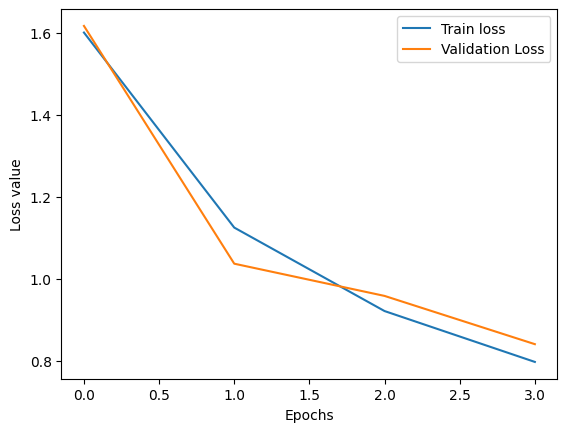

In [84]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

In [85]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in test_loader:
        model.eval()
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 72.55 %


In [23]:
# prompt: use neptune to track

!pip install neptune-client

import neptune.new as neptune

# Initialize Neptune
run = neptune.init_run(
    project="your-neptune-project",  # Replace with your Neptune project
    api_token="your-neptune-api-token"  # Replace with your Neptune API token
)

# ... your existing code ...

# Log hyperparameters
run["parameters/learning_rate"] = learning_rate
run["parameters/n_epochs"] = n_epochs

# Log metrics during training
for epoch in range(n_epochs):
    # ... your existing training loop ...

    run["train/loss"].log(loss_train)
    run["validation/loss"].log(validation_loss)
    run["epoch/time"].log(epoch_time)


# Log the final accuracy
run["metrics/test_accuracy"] = acc

# Stop the Neptune run
run.stop()

In [ ]:
# prompt: Make my CNN code a little more big. This is for CIFAR 10 dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from math import floor
import time
from tqdm import tqdm

# ... (rest of the code from the previous response)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512) # Adjusted for two maxpooling layers
        self.dropout = nn.Dropout(0.5) # Dropout for regularization
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = x.view(-1, 256 * 8 * 8)  # Reshape for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x

model = CNN()

# ... (rest of the training code remains largely the same)

# ... (rest of the code from the previous response)

In [70]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create a simple linear dataset
X = torch.linspace(1, 10, 10).reshape(-1, 1)
y = 2 * X + 3

# Define a transformation to add a constant value
def add_constant(x):
    return x + 5

# Create a transformation pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda x: add_constant(x))
])

def apply_transform(dataset, transform):
    dataset.transform = transform
    return dataset

# Create a dataset
dataset = TensorDataset(X, y)

# Apply the transformation to the dataset
dataset_new = apply_transform(dataset, transform)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate over the data loader
for X_batch, y_batch in data_loader:
    print(X_batch)
    # Now X_batch will have the constant added to each elem

tensor([[10.],
        [ 7.],
        [ 8.],
        [ 9.],
        [ 5.],
        [ 6.],
        [ 1.],
        [ 4.],
        [ 3.],
        [ 2.]])


In [75]:
next(iter(dataset))

(tensor([1.]), tensor([5.]))

In [76]:
next(iter(dataset_new))

(tensor([1.]), tensor([5.]))